# 6.2 Understanding Recurrent Neural Networks
A major characteristic of neural networks up to this point (densely connected networks and convnets) is that they have no memory. With these networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once, effectively turning it into a single data point. Such networks are called ***feedforward networks***.

Unlike the networks mentioned above, biological intelligence processes information incrementally while maintaining an internal model of what it's processing, built from past information and constantly updated as new information comes in. A ***recurrent neural network (RNN)*** adopts the same principle. It processes sequences by iterating through the sequence elements and maintaining a ***state*** containing information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop. The state of the RNN is reset between processing two different, independent sequences (such as two different movie reviews), so we still consider one sequence a single data point. What changes is that this data point is no longer processed in a single step, but the network internally loops over sequence elements.

![rnn](images/6_2_0_rnn.jpg)

Let's implement the forward pass of a toy RNN in Numpy. This RNN takes a sequence of vectors as inputs (encoded as a 2D tensor of shape (`timesteps, input_features`)). It loops over timesteps, and at each timestep, it considers its current state at `t` and the input at `t` (of shape (`input_features,`)), and combines them to obtain the output at `t`. We then set the state of the next step to be this previous output. There is no previous output for the first step, so we will initialize the state as an all-zero vector called the ***initial state*** of the network.

**PSEUDOCODE RNN**

In [ ]:
# the state at t
state_t = 0

# iterate over sequence elements
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t # previous output becomes state for next iteration

We can even expand on the function `f`: the transformation of the input and state into an output will be parameterized by two matrices, `W` and `U`, and a bias vector. This is similar to the transformation of a densely connected layer in a feedforward network.

**MORE DETAILED PSEUDOCODE RNN**

In [ ]:
# the state at t
state_t = 0

# iterate over sequence elements
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t # previous output becomes state for next iteration

Now let's write a naive Numpy implementaton of the forward pass of the simple RNN.

**NUMPY IMPLEMENTATION OF SIMPLE RNN**

In [1]:
import numpy as np

# number of timesteps in input sequence
timesteps = 100
input_features = 32 # dimensionality of the input feature space
output_features = 64 # dimensionality of the output feature space

# input data: random noise for the sake of example
inputs = np.random.random((timesteps, input_features))

# Initial state: all zero vector
state_t = np.zeros((output_features,))

# Create random weight matrices
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs: # input_t is vector of shape (input_features)
    # combine input with current state to get current output
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    
    # store output in a list
    successive_outputs.append(output_t)
    
    # Update the state of the network for next timestep
    state_t = output_t

# Final output is 2D tensor (timesteps, output_features)
final_output_sequence = np.concatenate(successive_outputs, axis=0)

In summary, an RNN is a `for` loop that reuses quantities computed during the previous iteration of the loop, nothing more. RNNs are characterized by their step function, such as the following function in this case:

In [2]:
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

![unrolled rnn](images/6_2_0_unrolledrnn.jpg)

## 6.2.1 A recurrent layer in Keras
The process we just implemented in Numpy corresponds to an actual Keras layer - the `SimpleRNN` layer:

In [3]:
from keras.layers import SimpleRNN

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The only difference is that the `SimpleRNN` layer processes batches of sequences, not a single sequence as in the Numpy example. This means it takes inputs of shape (`batch_size, timesteps, input_features`).

`SimpleRNN` can be run in two different modes: it can return either the full sequences of successive outputs for each timestep or only the last output for each input sequence. Let's look at an example that returns only the last timestep:

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [5]:
# The following returns the full state sequence
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Sometimes it's useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, we have to get all of the intermediate layers to return full sequence of outputs:

In [6]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary() # Last layer only returns last output

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's use such a model on the IMDB movie-review-classification problem.

**PREPROCESS IMDB DATA**

In [7]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000 # number of words to consider as features
maxlen = 500 # cuts off texts after this many words
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
(25000, 'train sequences')
(25000, 'test sequences')
Pad sequences (samples x time)
('input_train shape:', (25000, 500))
('input_test shape:', (25000, 500))


**TRAIN MODEL WITH EMBEDDING AND SimpleRNN LAYERS**

In [8]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 78s - loss: 0.6517 - acc: 0.6138 - val_loss: 0.5502 - val_acc: 0.7188
Epoch 2/10
20000/20000 [==============================] - 77s - loss: 0.4003 - acc: 0.8361 - val_loss: 0.3641 - val_acc: 0.8448
Epoch 3/10
20000/20000 [==============================] - 77s - loss: 0.2696 - acc: 0.8963 - val_loss: 0.4810 - val_acc: 0.8160
Epoch 4/10
20000/20000 [==============================] - 77s - loss: 0.2019 - acc: 0.9249 - val_loss: 0.4370 - val_acc: 0.8072
Epoch 5/10
20000/20000 [==============================] - 78s - loss: 0.1456 - acc: 0.9473 - val_loss: 0.3875 - val_acc: 0.8618
Epoch 6/10
20000/20000 [==============================] - 77s - loss: 0.1005 - acc: 0.9661 - val_loss: 0.4685 - val_acc: 0.8078
Epoch 7/10
20000/20000 [==============================] - 91s - loss: 0.0705 - acc: 0.9778 - val_loss: 0.5161 - val_acc: 0.8290
Epoch 8/10
20000/20000 [==============================]

**PLOT TRAINING/VALIDATION LOSS & ACCURACY**

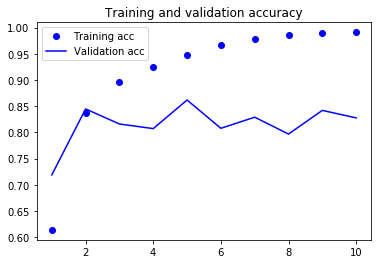

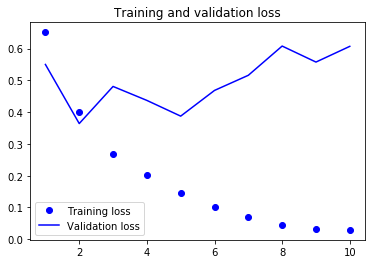

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In chapter 3, we applied a 3-layer dense network to this same problem and achieved 88% accuracy on our test set. Unfortunately, this small RNN doesn't perform well compared to our baseline only achieving ~85% validation accuracy. Part of the problem is that our inputs only consider the first 500 words, rather than full sequences - hence, the RNN has access to less information than the earlier baseline model. The remainder of the problem is that `SimpleRNN` isn't good at processing long sequences, such as text. Let's take a look at some other advanced layers that are better for analyzing long sequences.

## 6.2.2 Understanding LSTM and GRU layers
In addition to `SimpleRNN`, Keras provides two more recurrent layers: **`LSTM`** and **`GRU`**. In theory, `SimpleRNN` should be able to retain time `t` information about inputs seen several timesteps in the past, but such long-term dependencies are impossible to learn. This is due to the ***vanishing gradient problem***, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep. As you keep adding layers to a network, the network eventually becomes untrainable. The `LSTM` and `GRU` layers are designed to solve this problem.

The Long Short-Term Memory (LSTM) layer is a variant of the `SimpleRNN` layer that adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you are processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. The LSTM essentially saves information for later, which prevents older signals from gradually vanishing during processing.

To better visualize this, let's start with a `SimpleRNN` cell.

![simplernn](images/6_2_2_simplernn.jpg)

Let's add an additional data flow that carries information across timesteps. We will call its values at different timesteps `Ct`, where C stands for ***carry***. This information will be combined with the input connection and the recurrent connection, and it will affect the state being sent to the next timestep.

![lstm](images/6_2_2_lstm.jpg)

The way the next value of the carry dataflow is computed involves three distinct transformations that all have the form of a `SimpleRNN` cell:

`y = activation(dot(state_t, U) + dot(input_t, W) + b)`

But all three transformations have their own weight matrices, which we will index with the letters `i, f,` and `k`. Here's what we have so far:

**LSTM PSEUDOCODE 1/2**

In [ ]:
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(C_t, Vo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

We obtain the new carry state (c_t) by combining i_t, f_t, and k_t.

**LSTM PSEUDOCODE 2/2**

In [ ]:
c_t+1 = i_t * k_t + c_t * f_t

Here is our result:

![lstm2](images/6_2_2_lstm2.jpg)

Here's what is going on:
 - Multiplying **`c_t`** and **`f_t`** is a way to deliberately forget irrelevant information in the carry dataflow.
 - Meanwhile, **`i_t`** and **`k_t`** provide information about the present, updating the carry track with new information.
 
An `LSTM` cell is meant to allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.

## 6.2.3 A concrete LSTM example in Keras
Now we will set up a model using an `LSTM` layer and train it on the same IMDB data we have been working with. This network is very similar to the `SimpleRNN` network we built earlier that achieved 85% validation accuracy.

In [10]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 398s - loss: 0.5160 - acc: 0.7564 - val_loss: 0.4078 - val_acc: 0.8070
Epoch 2/10
20000/20000 [==============================] - 393s - loss: 0.2948 - acc: 0.8842 - val_loss: 0.4518 - val_acc: 0.8320
Epoch 3/10
20000/20000 [==============================] - 389s - loss: 0.2356 - acc: 0.9111 - val_loss: 0.4426 - val_acc: 0.7962
Epoch 4/10
20000/20000 [==============================] - 388s - loss: 0.2021 - acc: 0.9244 - val_loss: 0.2955 - val_acc: 0.8808
Epoch 5/10
20000/20000 [==============================] - 397s - loss: 0.1801 - acc: 0.9334 - val_loss: 0.2961 - val_acc: 0.8770
Epoch 6/10
20000/20000 [==============================] - 406s - loss: 0.1574 - acc: 0.9428 - val_loss: 0.2929 - val_acc: 0.8814
Epoch 7/10
20000/20000 [==============================] - 404s - loss: 0.1509 - acc: 0.9464 - val_loss: 0.3103 - val_acc: 0.8752
Epoch 8/10
20000/20000 [========================

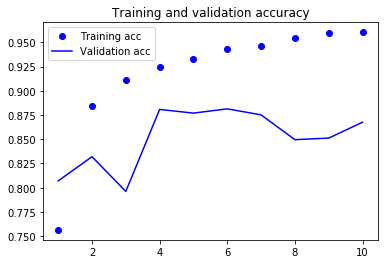

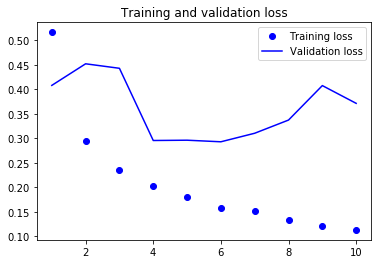

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This time we were able to achieve up to 88% validation accuracy. Not bad, and definitely better than the `SimpleRNN` network. This is mainly because the `LSTM` doesn't suffer as much from the vanishing-gradient problem. Also keep in mind, this performance was achieved from only looking at 500 timesteps.

You may be asking, why isn't LSTM performing better? One reason is that we made no effort to tune the hyperparameters such as embedding dimensionality or the LSTM output dimensionality. We also may be lacking regularization. But LSTM isn't helpful for analyzing a sentiment analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency. There are far more difficult natural-language-processing problems out there, where the strength of LSTM will become apparent: in particular, question-answering and machine translation.

In conclusion, we now have a better grasp on the following:
 - **What RNNs are and how they work**
 - **What LSTM is, and why it works better on long sequences than a naive RNN**
 - **How to use Keras RNN layers to process sequence data**